<a href="https://colab.research.google.com/github/manujism/Statistical-Arbitrage-Model/blob/main/Finalised_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Statical Arbitrage - Pair Trading Code

In [4]:
# @title Installing Libraries

import numpy as np
import pandas as pd
import seaborn as sns
import yfinance as yf
import statsmodels.api as sm
from datetime import datetime, timedelta
import warnings
import matplotlib.pyplot as plt


[*********************100%***********************]  2 of 2 completed


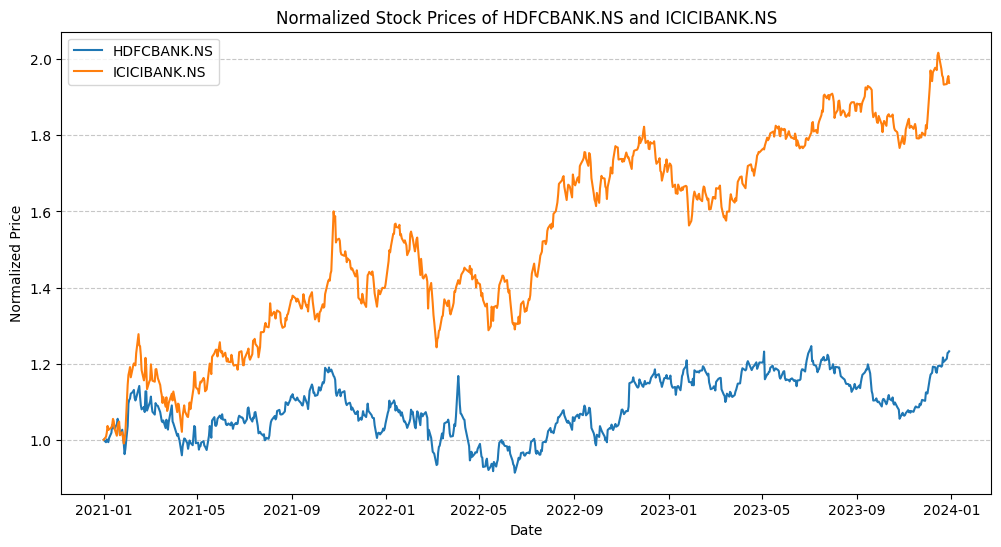

In [17]:
# @title Data Collection

warnings.filterwarnings("ignore", category=FutureWarning)
tickers = ['HDFCBANK.NS', 'ICICIBANK.NS']
end_date = "2023-12-31"
start_date = "2021-01-01"

df = yf.download(tickers, start=start_date, end=end_date)['Close']
df.head()
normalized_df = df / df.iloc[0]

plt.figure(figsize=(12, 6))
for ticker in tickers:
    plt.plot(normalized_df[ticker], label=f"{ticker}")
plt.title(f"Normalized Stock Prices of {tickers[0]} and {tickers[1]}")
plt.xlabel("Date")
plt.ylabel("Normalized Price")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

window = 60 # for rolling analysis


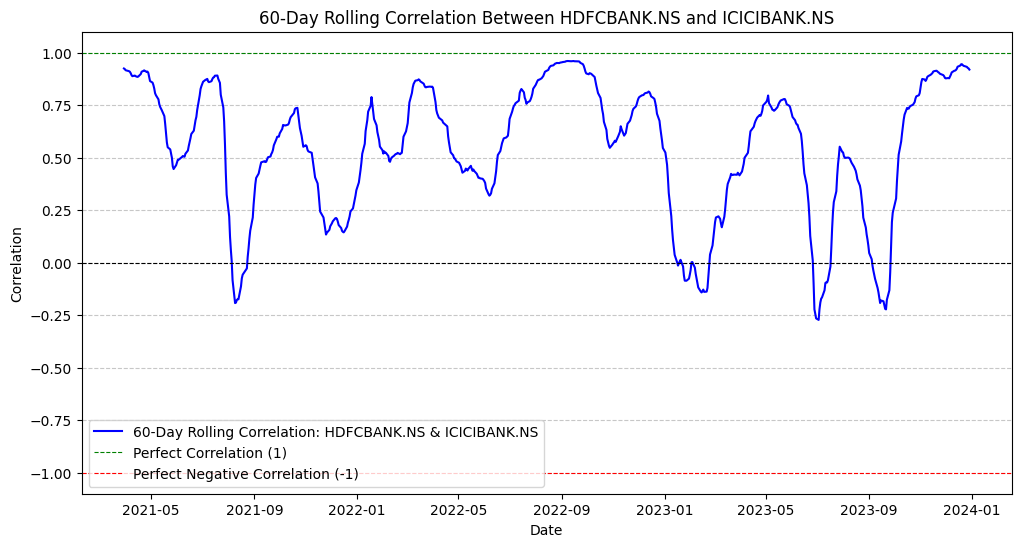

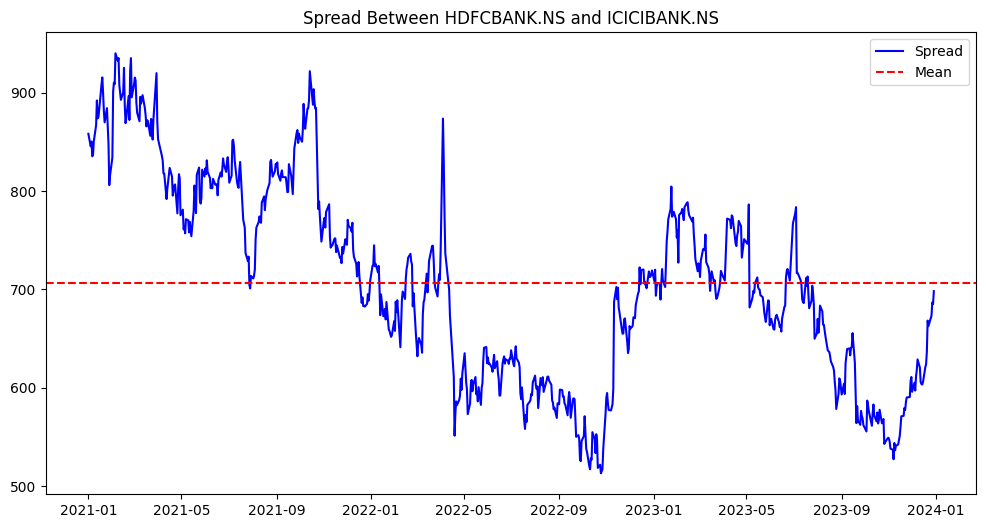

In [18]:
# @title Data Processing

rolling_corr = df[tickers[0]].rolling(window=window).corr(df[tickers[1]])

plt.figure(figsize=(12, 6))
plt.plot(rolling_corr, label=f"60-Day Rolling Correlation: {tickers[0]} & {tickers[1]}", color="blue")
plt.title(f"60-Day Rolling Correlation Between {tickers[0]} and {tickers[1]}")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)  # Reference line at 0
plt.axhline(1, color="green", linestyle="--", linewidth=0.8, label="Perfect Correlation (1)")
plt.axhline(-1, color="red", linestyle="--", linewidth=0.8, label="Perfect Negative Correlation (-1)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

spread = df[tickers[0]] - df[tickers[1]]

plt.figure(figsize=(12, 6))
plt.plot(spread, label="Spread", color="blue")
plt.axhline(spread.mean(), color="red", linestyle="--", label="Mean")
plt.title(f"Spread Between {tickers[0]} and {tickers[1]}")
plt.legend()
plt.show()



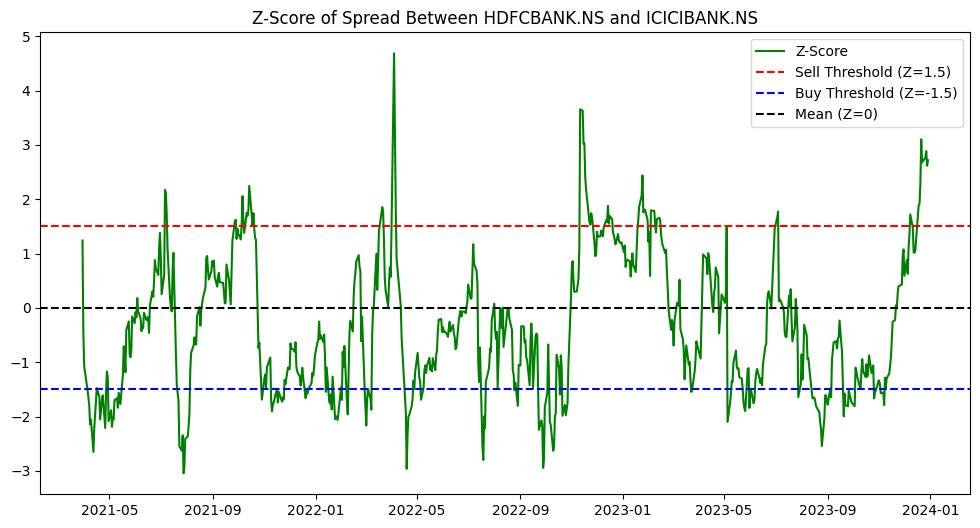

In [19]:
# @title Z-Score Calculation

rolling_mean = spread.rolling(window).mean()
rolling_std = spread.rolling(window).std()

# Calculating Z-score
z_score = (spread - rolling_mean) / rolling_std

# Plotting the Z-score
plt.figure(figsize=(12, 6))
plt.plot(z_score, label="Z-Score", color="green")
plt.axhline(1.5, color="red", linestyle="--", label="Sell Threshold (Z=1.5)")
plt.axhline(-1.5, color="blue", linestyle="--", label="Buy Threshold (Z=-1.5)")
plt.axhline(0, color="black", linestyle="--", label="Mean (Z=0)")
plt.title(f"Z-Score of Spread Between {tickers[0]} and {tickers[1]}")
plt.legend()
plt.show()

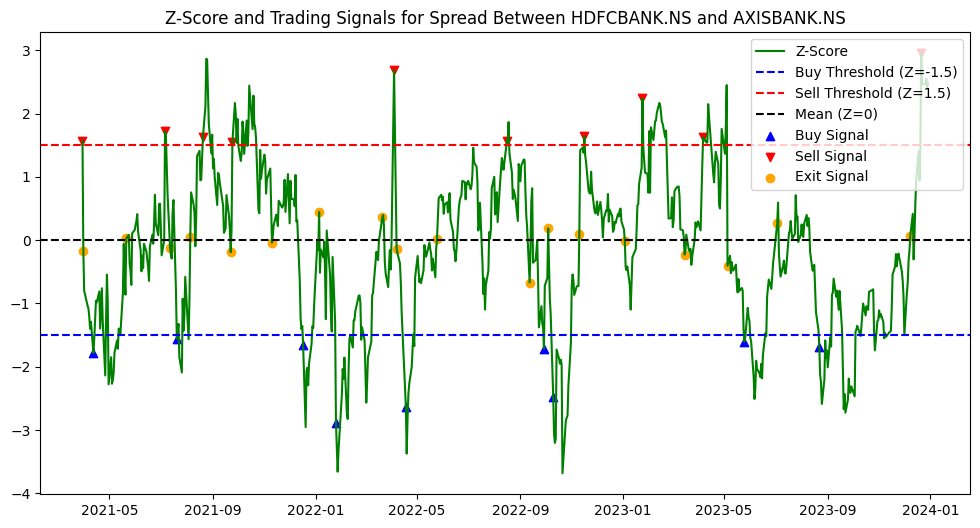

In [8]:
# @title Trading Setup

buy_threshold = -1.5
sell_threshold = 1.5
exit_above_zero = 0
exit_below_zero = 0


position = 0  # 0: Neutral, 1: Long, -1: Short
positions = []  # Store the position at each time step
buy_signals = []  # Indexes of buy signals
sell_signals = []  # Indexes of sell signals
exit_signals = []  # Indexes of exit signals


for i, z in enumerate(z_score):
    if position == 0:  # Neutral position

        if z < buy_threshold:
            position = 1  # Buy signal
            buy_signals.append(i)

        elif z > sell_threshold:
            position = -1  # Sell signal
            sell_signals.append(i)

    elif position == 1:  # Long position
        if z > exit_above_zero:
            position = 0
            exit_signals.append(i)

    elif position == -1:  # Short position
        if z < exit_below_zero:
            position = 0  # Exit short position
            exit_signals.append(i)

    positions.append(position)  # Append the current position at each iteration


positions = positions[:len(z_score)]

signals = pd.DataFrame(index=z_score.index)
signals['Position'] = positions
signals['Buy'] = signals.index.isin(z_score.index[buy_signals])
signals['Sell'] = signals.index.isin(z_score.index[sell_signals])
signals['Exit'] = signals.index.isin(z_score.index[exit_signals])


plt.figure(figsize=(12, 6))
plt.plot(z_score, label="Z-Score", color="green")
plt.axhline(buy_threshold, color="blue", linestyle="--", label="Buy Threshold (Z=-1.5)")
plt.axhline(sell_threshold, color="red", linestyle="--", label="Sell Threshold (Z=1.5)")
plt.axhline(0, color="black", linestyle="--", label="Mean (Z=0)")


plt.scatter(signals.index[signals['Buy']], z_score[signals['Buy']],
            label="Buy Signal", color="blue", marker="^")
plt.scatter(signals.index[signals['Sell']], z_score[signals['Sell']],
            label="Sell Signal", color="red", marker="v")
plt.scatter(signals.index[signals['Exit']], z_score[signals['Exit']],
            label="Exit Signal", color="orange", marker="o")
plt.title(f"Z-Score and Trading Signals for Spread Between {tickers[0]} and {tickers[1]}")
plt.legend()
plt.show()

Ticker          Spread  Spread_Return
Date                                 
2021-01-01  858.105133            NaN
2021-01-04  845.357300      -0.014856
2021-01-05  850.264038       0.005804
2021-01-06  835.225159      -0.017687
2021-01-07  836.510620       0.001539


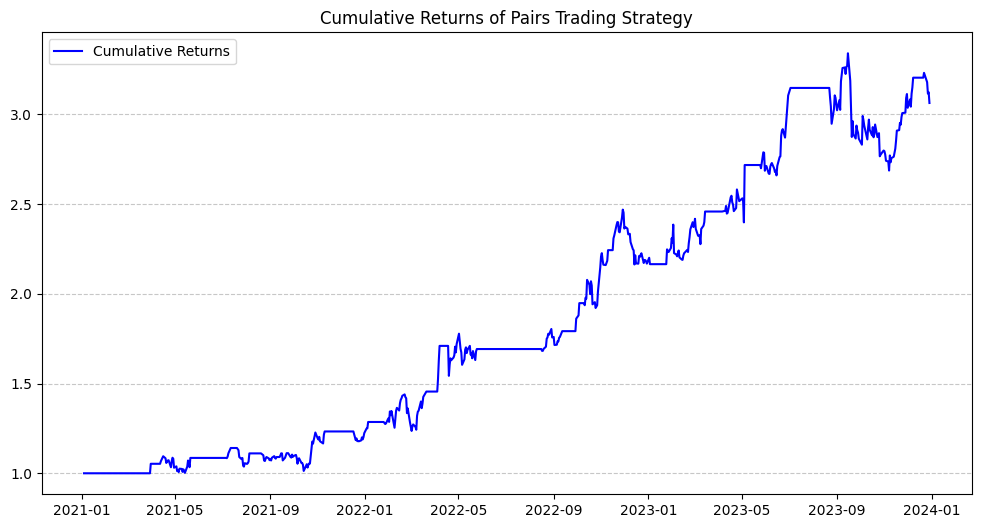

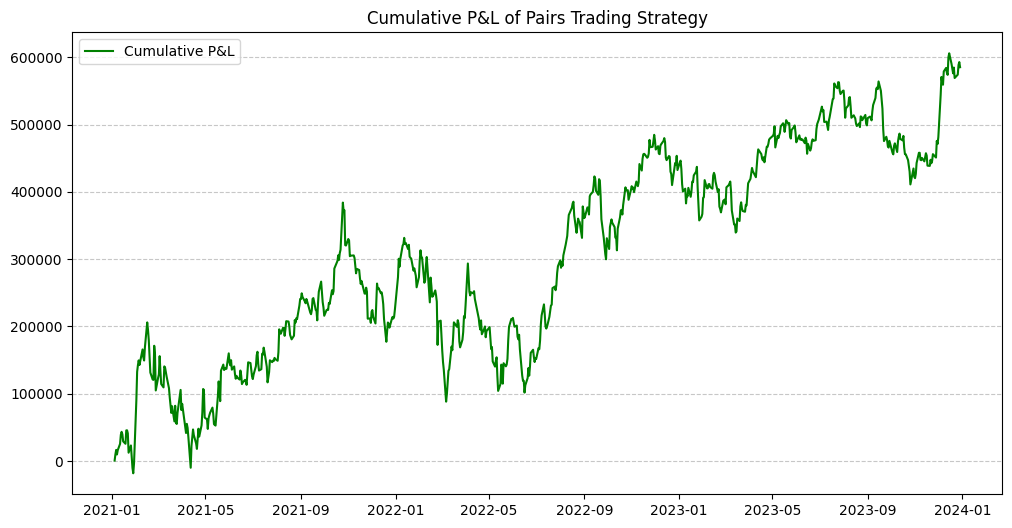

In [20]:
# @title Backtesting

initial_capital = 1000000  # INR Ten Lakhs
capital_per_stock = initial_capital / 2
df['Stock1_Position'] = capital_per_stock / df[tickers[0]].iloc[0]  # Position in Asset1
df['Stock2_Position'] = capital_per_stock / df[tickers[1]].iloc[0]  # Position in Asset2


df['Spread'] = df[tickers[0]] - df[tickers[1]]


df['Spread_Return'] = (df['Spread'] - df['Spread'].shift(1)) / df['Spread'].shift(1)

print(df[['Spread', 'Spread_Return']].head())


df['percentage_change'] = (df['Spread'] - df['Spread'].shift(1)) / df['Spread'].shift(1)


df['Strategy_Returns'] = signals['Position'].shift(1) * df['percentage_change']


df['Cumulative_Returns'] = (df['Strategy_Returns'] + 1).cumprod()


total_returns = (df['Cumulative_Returns'].iloc[-1] - 1) * 100


plt.figure(figsize=(12, 6))
plt.plot(df['Cumulative_Returns'], label="Cumulative Returns", color="blue")
plt.title(f"Cumulative Returns of Pairs Trading Strategy")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

df['Strategy_PnL'] = (df['Stock1_Position'] * (df[tickers[0]] - df[tickers[0]].shift(1))) + \
                      (df['Stock2_Position'] * (df[tickers[1]] - df[tickers[1]].shift(1)))


df['Cumulative_PnL'] = df['Strategy_PnL'].cumsum()


plt.figure(figsize=(12, 6))
plt.plot(df['Cumulative_PnL'], label="Cumulative P&L", color="green")
plt.title(f"Cumulative P&L of Pairs Trading Strategy")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.show()

In [22]:
# @title Metrics Calculation


df['Trade'] = signals['Position'].diff().fillna(0)

trades = df[df['Trade'] != 0].copy()


trades['Trade_Return'] = trades['Cumulative_Returns'].diff().fillna(0)

winning_trades = trades[trades['Trade_Return'] > 0]


total_trades = len(trades) - 1  # Excluding the first row as it's not a complete trade
winning_trades_count = len(winning_trades)
win_rate = (winning_trades_count / total_trades) * 100 if total_trades > 0 else 0

print(f"Total Trades: {total_trades}")
print(f"Winning Trades: {winning_trades_count}")
print(f"Win Rate: {win_rate:.2f}%")


total_strategy_return = (df['Cumulative_Returns'].iloc[-1] - 1) * 100


print(f"Total Return of Strategy: {total_strategy_return:.2f}%")


df['PnL'] = df['Strategy_Returns'] * initial_capital


df['Profit'] = df['PnL'].apply(lambda x: x if x > 0 else 0)  # Only positive PnL (profits)
df['Loss'] = df['PnL'].apply(lambda x: abs(x) if x < 0 else 0)  # Only negative PnL (losses)


total_profit = df['Profit'].sum()
total_loss = df['Loss'].sum()


pnl_ratio = total_profit / total_loss if total_loss != 0 else float('inf')  # Avoiding division by zero

print(f"PnL Ratio: {pnl_ratio:.2f}")

Total Trades: 36
Winning Trades: 15
Win Rate: 41.67%
Total Return of Strategy: 206.23%
PnL Ratio: 1.42
